# Ungraded Lab: Cats vs. Dogs Class Activation Maps

## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

2024-07-26 08:50:23.357155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 08:50:23.357305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 08:50:23.486685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and Prepare the Dataset

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete03111V/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

## Build the classifier

In [4]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
model.fit(train_batches,epochs=25)

Epoch 1/25


2024-07-26 08:51:54.005671: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180000: 3.34346, expected 2.84536
2024-07-26 08:51:54.005738: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180001: 3.65325, expected 3.15516
2024-07-26 08:51:54.005749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180008: 3.91897, expected 3.42087
2024-07-26 08:51:54.005757: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180023: 3.90653, expected 3.40844
2024-07-26 08:51:54.005765: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180029: 3.94016, expected 3.44207
2024-07-26 08:51:54.005773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180031: 3.85116, expected 3.35306
2024-07-26 08:51:54.005781: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180032: 3.82861, expected 3.33052
2024-07-26 08:51:54.

  3/582 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.4705 - loss: 0.7152  

I0000 00:00:1721983919.772687     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5419 - loss: 0.6878

2024-07-26 08:52:25.099076: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90000: 3.52466, expected 2.72593
2024-07-26 08:52:25.099131: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90001: 4.51216, expected 3.71343
2024-07-26 08:52:25.099141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90002: 3.85405, expected 3.05532
2024-07-26 08:52:25.099149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90003: 5.40604, expected 4.60731
2024-07-26 08:52:25.099157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90004: 5.41839, expected 4.61966
2024-07-26 08:52:25.099165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90005: 4.30413, expected 3.5054
2024-07-26 08:52:25.099172: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90006: 5.4887, expected 4.68997
2024-07-26 08:52:25.099180: E

582/582 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5420 - loss: 0.6878
Epoch 2/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.6116 - loss: 0.6558
Epoch 3/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.6440 - loss: 0.6401
Epoch 4/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.6365 - loss: 0.6602
Epoch 5/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5085 - loss: 0.7599
Epoch 6/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.5167 - loss: 0.8301
Epoch 7/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.5479 - loss: 0.7497
Epoch 8/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.5576 - loss: 0.9123
Epoch 9/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.5645 - loss: 0.9288
Epoch 10/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5638 - loss: 0.9589
Epoch 11/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5772 - loss: 0.9404
Epoch 12/25
582/582 ━━━━━━━━━━━━━━━━━━━━ 

## Building the CAM model

In [6]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.inputs,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        448 │ input_layer[0][0… │
│                     │ 16)               │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[6][0],     │
│ (MaxPooling2D)      │ 16)               │            │ conv2d[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │      4,640 │ max_pooling2d[5]… │
│                     │ 32)               │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_1[4][0],   │
│ (MaxPooling2D)      │ 32)               │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_2[2][0],   │
│ (MaxPooling2D)      │ 64)               │            │ conv2d_2[4][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_3[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,569 (381.13 KB)

 Trainable params: 97,569 (381.13 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

## Testing the Model

In [8]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-26 09:01:33--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.207, 142.250.157.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: 'cat1.jpg'

cat1.jpg            100%[===================>] 405.10K   647KB/s    in 0.6s    

2024-07-26 09:01:34 (647 KB/s) - 'cat1.jpg' saved [414826/414826]

--2024-07-26 09:01:36--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.207, 64.233.189.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving 

2024-07-26 09:01:45.320538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450000: 4.19521, expected 3.54036
2024-07-26 09:01:45.320606: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450001: 4.45805, expected 3.8032
2024-07-26 09:01:45.320621: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450002: 4.96368, expected 4.30883
2024-07-26 09:01:45.320634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450004: 5.31594, expected 4.66108
2024-07-26 09:01:45.320653: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450006: 5.10236, expected 4.4475
2024-07-26 09:01:45.320667: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450007: 5.45626, expected 4.8014
2024-07-26 09:01:45.320678: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450008: 4.77586, expected 4.12101
2024-07-26 09:01:45.320

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
sigmoid output: [[0.]]
prediction: cat


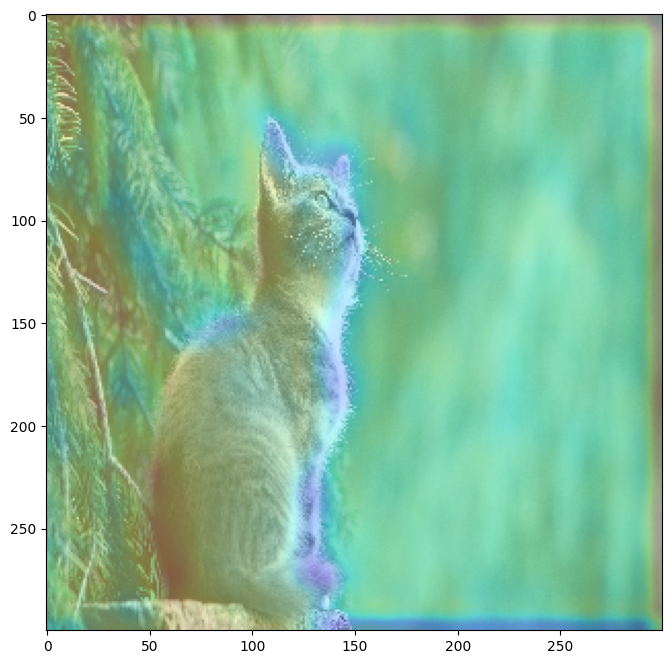

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.]]
prediction: cat


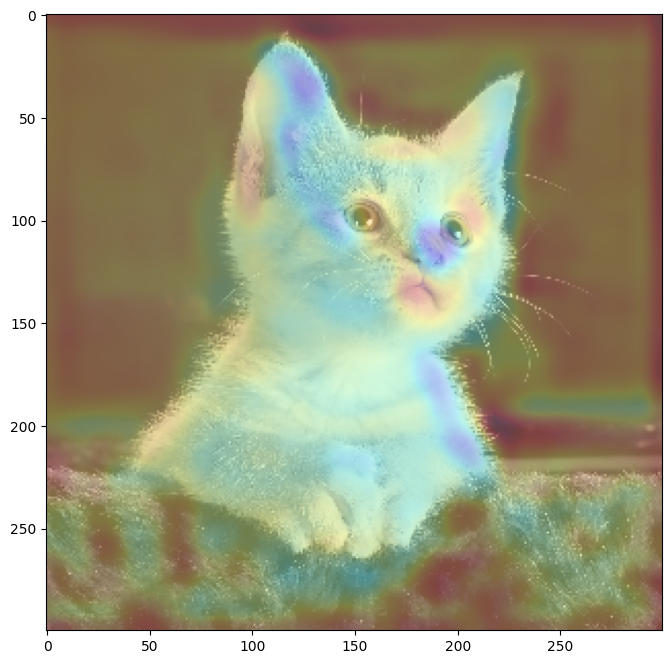

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
sigmoid output: [[0.]]
prediction: cat


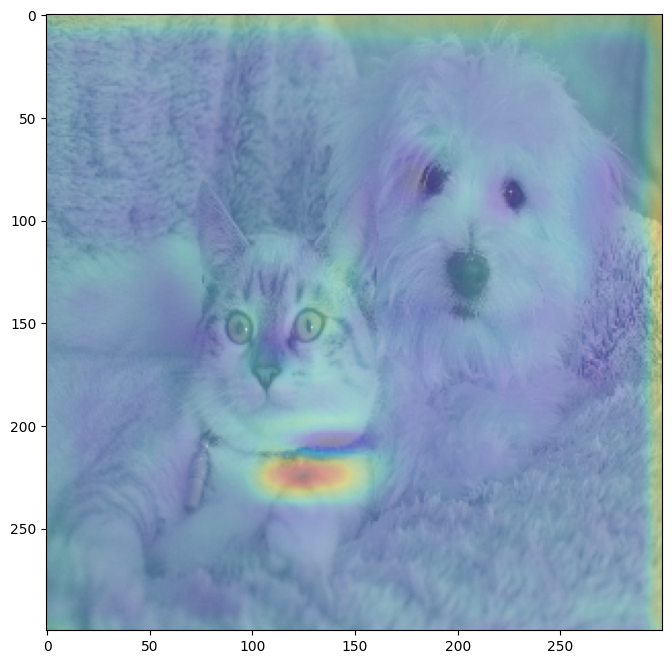

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
sigmoid output: [[0.]]
prediction: cat


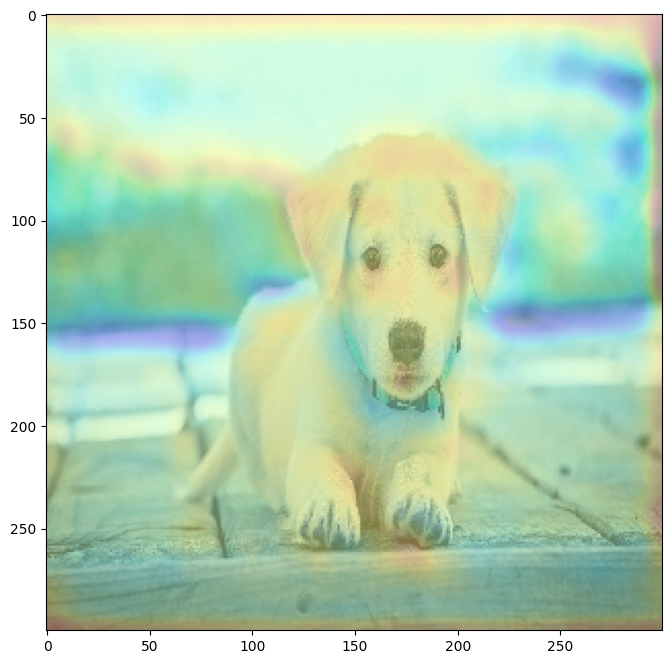

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.]]
prediction: cat


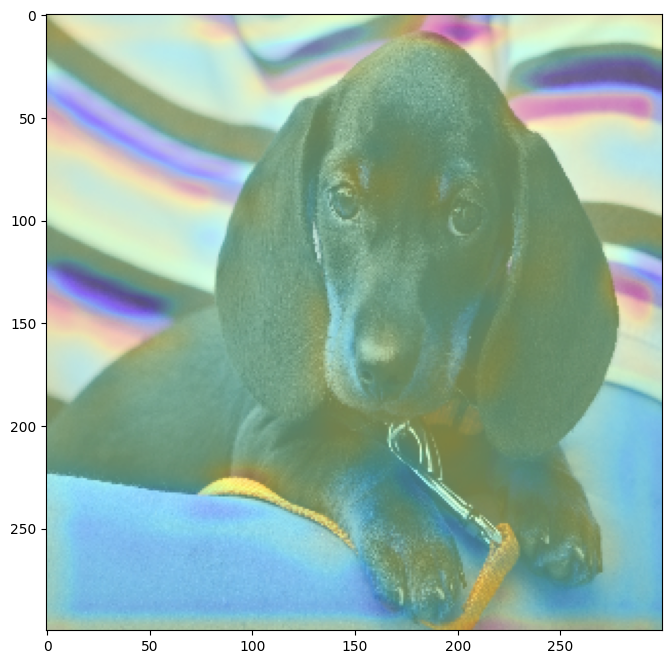

In [9]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.]]
prediction: cat


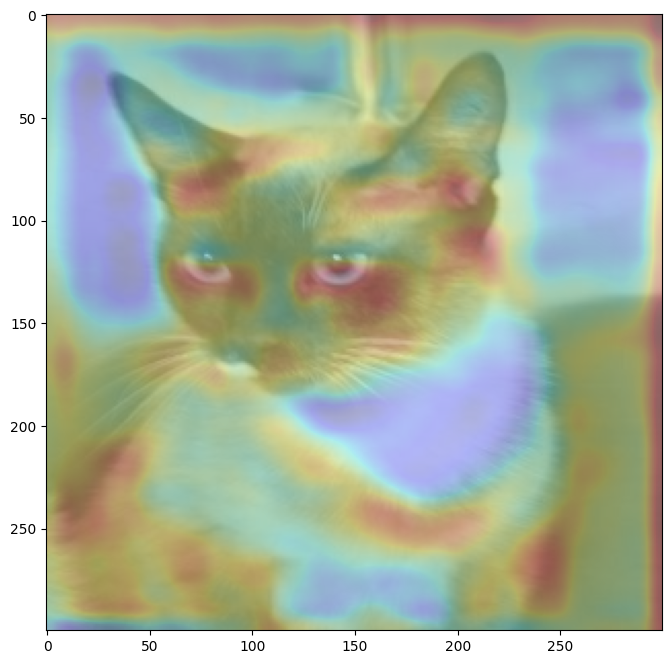

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.]]
prediction: cat


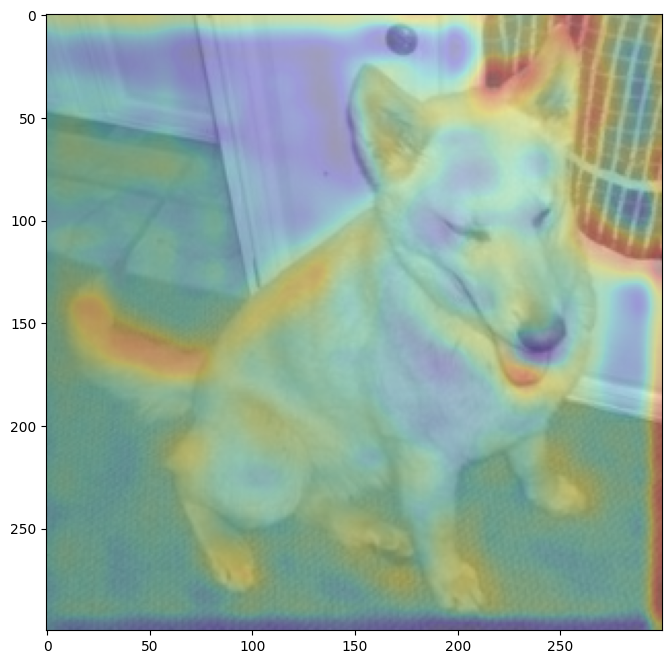

ground truth: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
sigmoid output: [[0.]]
prediction: cat


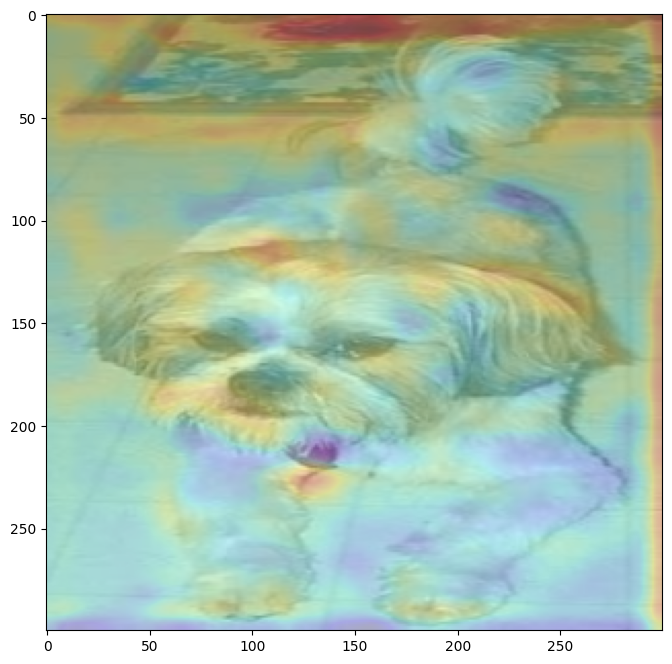

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sigmoid output: [[0.]]
prediction: cat


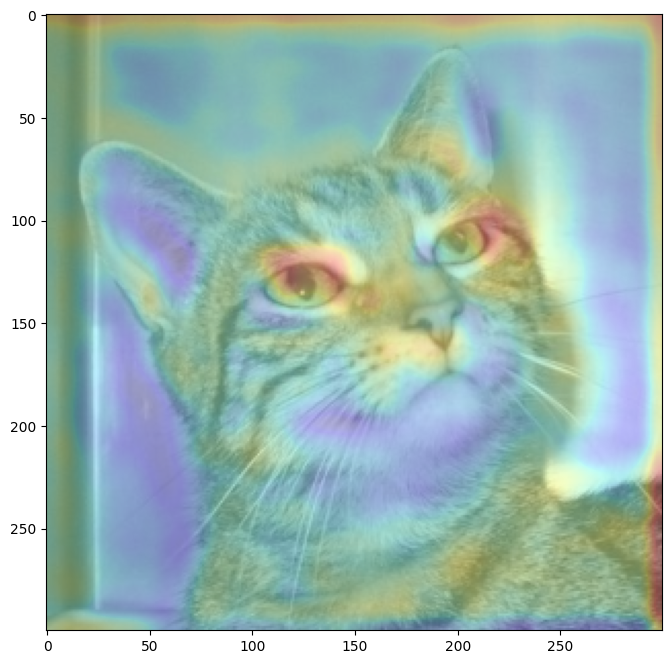

ground truth: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sigmoid output: [[0.]]
prediction: cat


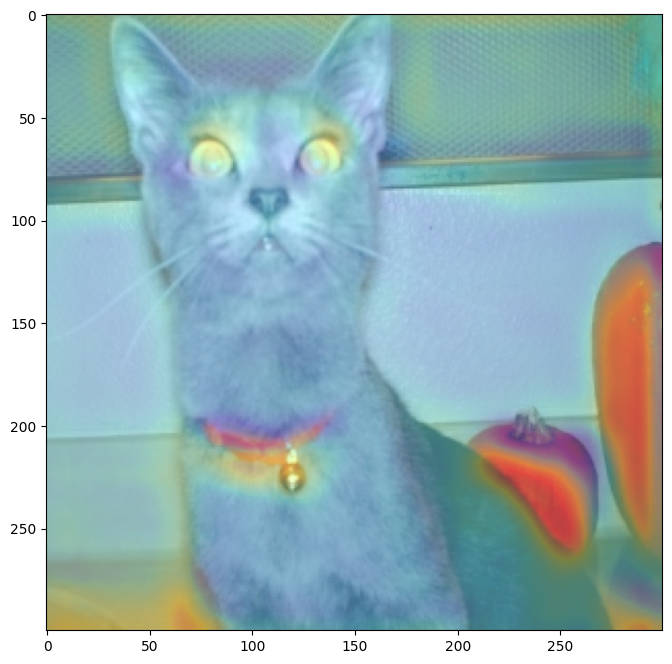

In [10]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)